<a href="https://colab.research.google.com/github/DJCordhose/buch-machine-learning-notebooks/blob/master/kap10-bert-fine-tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERT sentiment fine tuning auf der

**hierfür brauchen wir eine GPU*

* https://colab.research.google.com/github/huggingface/notebooks/blob/main/transformers_doc/en/tensorflow/training.ipynb
* https://huggingface.co/docs/transformers/training#train-a-tensorflow-model-with-keras
* https://huggingface.co/docs/datasets/
* https://github.com/huggingface/datasets
* https://huggingface.co/datasets/imdb

## Installation

In [1]:
import sys
IN_COLAB = 'google.colab' in sys.modules
IN_COLAB

True

In [2]:
if IN_COLAB:
    # https://huggingface.co/transformers/installation.html
    # https://huggingface.co/docs/datasets/installation.html
    # !pip install -q transformers
    !pip install -q datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 15.4 MB/s eta 0:00:00


In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 8)
mpl.rcParams['axes.titlesize'] = 24
mpl.rcParams['axes.labelsize'] = 20

figsize_3d = (20, 10)

In [5]:
import tensorflow as tf
tf.__version__

'2.15.0'

In [6]:
tf.random.set_seed(42)

In [7]:
# je mehr Bums desto besser
# A100 > V100 > L4 > T4 > CPU
!nvidia-smi

Thu May 16 14:50:53 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Daten holen und vorbereiten

In [8]:
from datasets import load_dataset

raw_datasets = load_dataset("imdb")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [9]:
raw_datasets

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    unsupervised: Dataset({
        features: ['text', 'label'],
        num_rows: 50000
    })
})

In [10]:
example_idx = 0
raw_datasets["train"]['text'][example_idx]

'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, ev

In [11]:
# 0: neg, 1: pos
raw_datasets["train"]['label'][example_idx]

0

In [12]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [13]:
del raw_datasets["unsupervised"]

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [14]:
# train_dataset = tokenized_datasets["train"]
# eval_dataset = tokenized_datasets["test"]

## Fine Tuning des vortrainierten Modells

In [15]:
small_size = 1_000
train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(small_size))
eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(small_size))

In [16]:
import tensorflow as tf
from transformers import TFAutoModelForSequenceClassification

model = TFAutoModelForSequenceClassification.from_pretrained("bert-base-cased")
model.summary()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
 dropout_37 (Dropout)        multiple                  0 (unused)
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 108311810 (413.18 MB)
Trainable params: 108311810 (413.18 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
# 1 to 3 minutes per epoch on decent GPU (e.g. V100 1min, T4 3min)
# don't train for too long, model will overfit
EPOCHS = 5
# reduce batch size when you encoder OOM error
# note, model has more than 100M parameters
# batch size 8 doable on 16GB
BATCH_SIZE = 8
# don't forget, we are fine tuning, increasing the LR might keep the model from even training
# LR = 3e-5
LR = 1e-5

In [18]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator(return_tensors="tf")

tf_train_dataset = train_dataset.to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols="label",
    shuffle=True,
    collate_fn=data_collator,
    batch_size=BATCH_SIZE,
)

tf_validation_dataset = eval_dataset.to_tf_dataset(
    columns=["attention_mask", "input_ids", "token_type_ids"],
    label_cols="label",
    shuffle=False,
    collate_fn=data_collator,
    batch_size=BATCH_SIZE,
)

In [19]:
%%time

model.compile(
   optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
    # You don’t have to pass a loss argument to your models when you compile() them!
    # Hugging Face models automatically choose a loss that is appropriate for their task and model architecture if this argument is left blank.
    # You can always override this by specifying a loss yourself if you want to!
    # loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=tf.metrics.SparseCategoricalAccuracy()
)

history = model.fit(tf_train_dataset, validation_data=tf_validation_dataset, epochs=EPOCHS)

Epoch 1/5


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
125/125 [==============================] - 307s 2s/step - loss: 0.5823 - sparse_categorical_accuracy: 0.6640 - val_loss: 0.3524 - val_sparse_categorical_accuracy: 0.8410
Epoch 2/5
125/125 [==============================] - 170s 1s/step - loss: 0.2640 - sparse_categorical_accuracy: 0.8980 - val_loss: 0.3567 - val_sparse_categorical_accuracy: 0.8680
Epoch 3/5
125/125 [==============================] - 207s 2s/step - loss: 0.1108 - sparse_categorical_accuracy: 0.9620 - val_loss: 0.4128 - val_sparse_categorical_accuracy: 0.8810
Epoch 4/5
125/125 [==============================] - 170s 1s/step - loss: 0.0526 - sparse_categorical_accuracy: 0.9870 - val_loss: 0.4780 - val_sparse_categorical_accuracy: 0.8760
Epoch 5/5
125/125 [==============================] - 207s 2s/step - loss: 0.0369 - sparse_categorical_accuracy: 0.9870 - val_loss: 0.4653 - val_sparse_c

## Trainiertes Modell evaluieren

In [20]:
model.evaluate(tf_train_dataset)

125/125 [==============================] - 46s 368ms/step - loss: 0.0139 - sparse_categorical_accuracy: 0.9970


[0.013858703896403313, 0.996999979019165]

In [21]:
# training data set too small to not overfit on it
model.evaluate(tf_validation_dataset)

125/125 [==============================] - 43s 347ms/step - loss: 0.4653 - sparse_categorical_accuracy: 0.8720


[0.4653184711933136, 0.871999979019165]

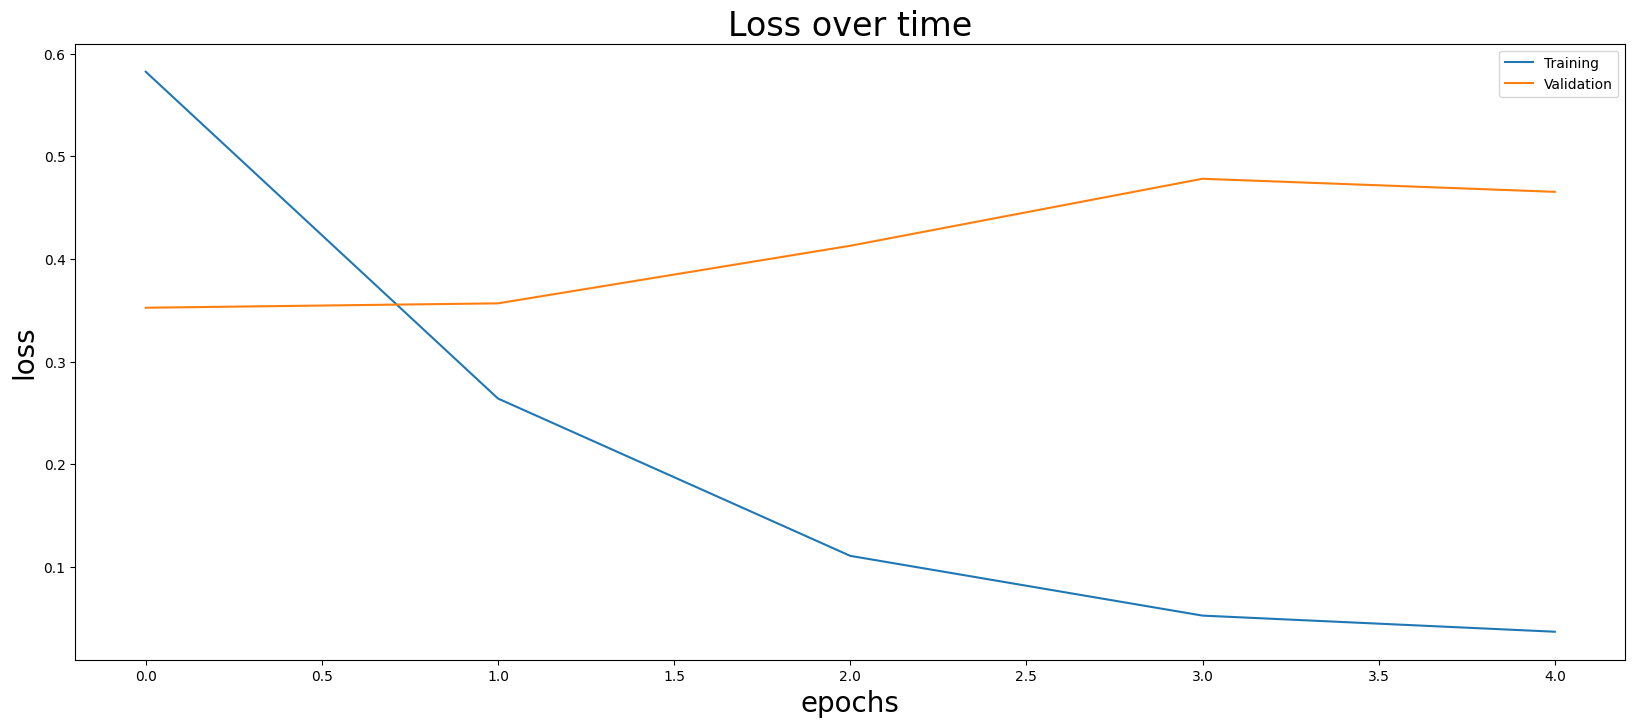

In [22]:
# plt.yscale('log')
plt.ylabel("loss")
plt.xlabel("epochs")
plt.title('Loss over time')

plt.plot(history.history['loss']);
plt.plot(history.history['val_loss']);

plt.legend(['Training', 'Validation']);

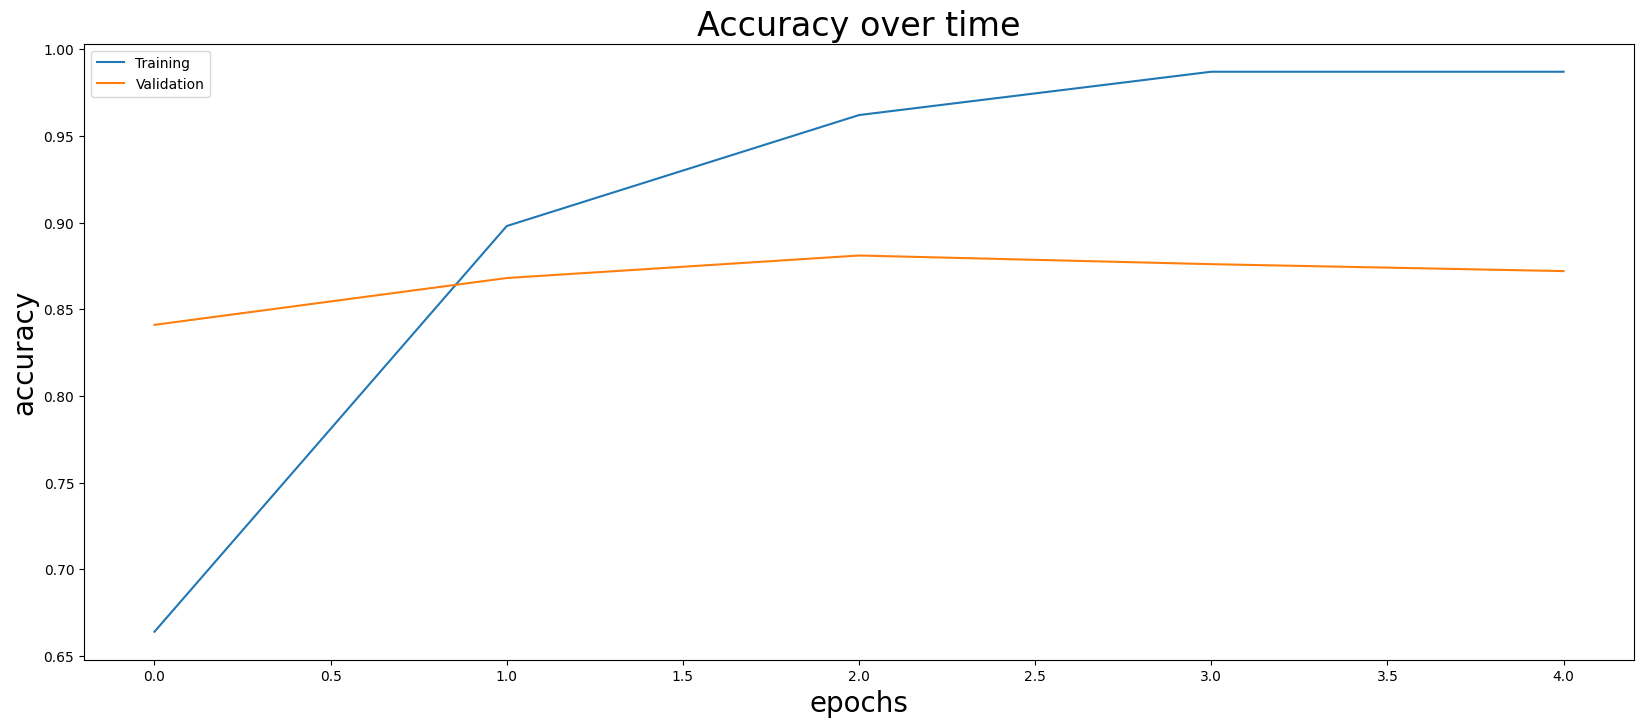

In [23]:
# plt.yscale('log')
plt.ylabel("accuracy")
plt.xlabel("epochs")
plt.title('Accuracy over time')

plt.plot(history.history['sparse_categorical_accuracy']);
plt.plot(history.history['val_sparse_categorical_accuracy']);

plt.legend(['Training', 'Validation']);


## Anekdotiches ausprobieren

Der Datensatz ist Englisch, also nur englische Beispiele sinnvoll

https://huggingface.co/datasets/imdb
* neg: 0
* pos: 1

https://huggingface.co/transformers/task_summary.html#sequence-classification

In [24]:
movie1 = 'Two small cats seek and find adventures. Nice if you like cute movies.'

In [25]:
movie2 = 'Zombies attack a kindergarden. Splatter!'

In [26]:
movies = [movie1, movie2]

In [27]:
inputs = tokenizer(movies, padding="max_length", truncation=True, return_tensors="tf")

In [28]:
# this seems to be a good movie
tf.nn.softmax(model(inputs)[0])[0].numpy()

array([0.04970243, 0.95029753], dtype=float32)

In [29]:
# this one not so much
tf.nn.softmax(model(inputs)[0])[1].numpy()

array([0.70871097, 0.291289  ], dtype=float32)